<a href="https://colab.research.google.com/github/halldm2000/NOAA-AI-2020-TUTORIAL/blob/master/curve_fit_wind_vs_pressure_v0_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Install Python Package for reading NetCDF files**

In [1]:
!pip install -q netCDF4

     |████████████████████████████████| 4.3MB 9.5MB/s 
     |████████████████████████████████| 296kB 51.8MB/s 


**Download Data from NOAA**

In [2]:
import os
source = "https://www.ncei.noaa.gov/data/international-best-track-archive-for-climate-stewardship-ibtracs/v04r00/access/netcdf/IBTrACS.ALL.v04r00.nc"
dest    = "data/ibtracs/"
!wget -q -c -e robots=off -P {dest} {source}

**Read Cyclone Data From File**

In [3]:
import xarray as xr, numpy as np

# read data from file
ds   = xr.open_dataset("/content/data/ibtracs/IBTrACS.ALL.v04r00.nc")
wind = ds['usa_wind'].data
pres = ds['usa_pres'].data
lat  = ds['usa_lat'].data

# find indices where both variables are valid
wind_valid = ~np.isnan(wind)
pres_valid = ~np.isnan(pres)
valid      = np.logical_and(pres_valid,wind_valid)

# keep only valid data
wind = wind[valid]
pres = pres[valid]
lat  = lat [valid]

**Plot Pressure vs Windspeed**

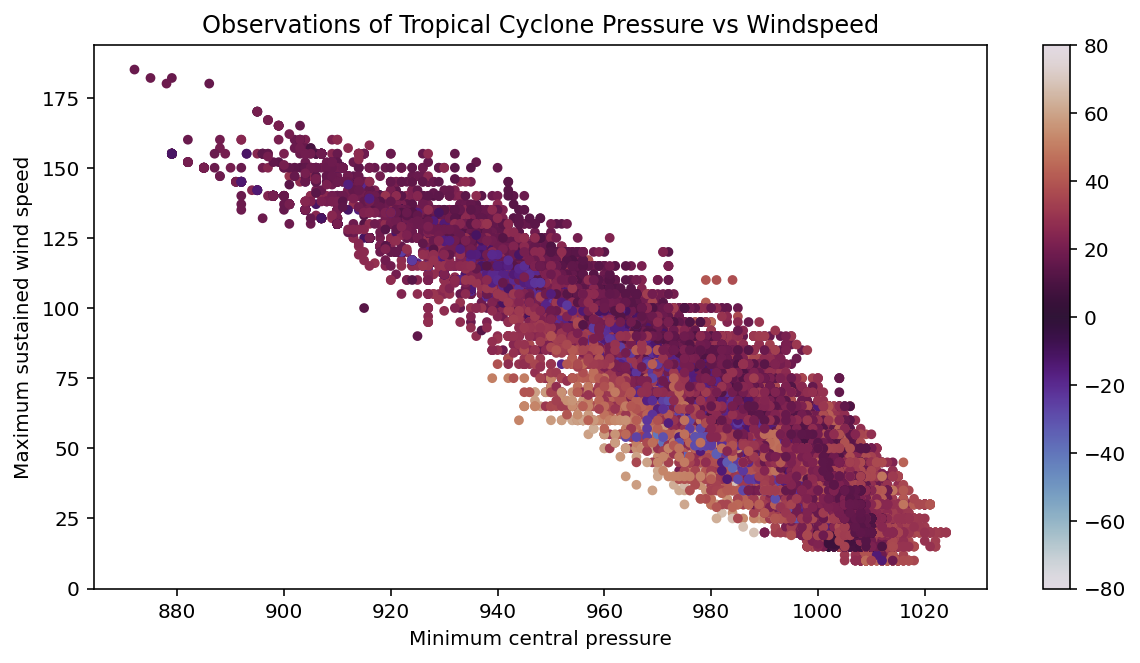

In [28]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5),dpi=2*72)
plt.scatter(pres,wind,c=lat,s=15,alpha=1,cmap='twilight')
plt.title("Observations of Tropical Cyclone Pressure vs Windspeed")
plt.xlabel(ds['usa_pres'].long_name)
plt.ylabel(ds['usa_wind'].long_name);
plt.ylim(bottom=0);
plt.clim(-80,80)
plt.colorbar(drawedges=False);

**Define routine for plotting curve-fit and training loss**

In [88]:
def plot_fit_and_loss(train_loss):

  plt.figure(figsize=(10,5), dpi=72*1.5)

  if True:

    # generate evenly spaced input points

    p     = np.linspace(850,1025,200, dtype=np.float32)
    l     = np.ones(200, dtype=np.float32)*20.0

    p     = p.reshape(-1,1)
    l     = l.reshape(-1,1)

    P = pscaler.transform(p)
    L = lscaler.transform(l)
    X = np.hstack([P,L])

    input = torch.from_numpy(X)
    pred  = model(input)
    w     = wscaler.inverse_transform(pred)

  # plot observations and fit
    plt.subplot(1, 2, 1)
    plt.scatter(pres,wind,c=lat,s=15,alpha=1,cmap='twilight')
    plt.scatter(p,w,c=l,s=5,alpha=1,cmap='twilight')
    plt.xlabel(ds['usa_pres'].long_name)
    plt.ylabel(ds['usa_wind'].long_name);
    plt.ylim(bottom=0)
    plt.clim(-80,80)
    plt.colorbar(drawedges=False);  

  if len(train_loss) > 0:
    # plot training loss vs batch number
    plt.subplot(1, 2, 2)
    plt.semilogy(train_loss)
    plt.xlabel("batch number")
    plt.ylabel("training loss")
    plt.ylim(bottom=1e-2)

  plt.show()


**Train a neural net to fit the observations**

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

import torch, torch.nn as nn, torch.optim as optim, torch.utils.data as data
from sklearn.preprocessing import StandardScaler

import time

# DATA

# reshape data to (nsamples, nvariables)
p = pres.reshape(-1,1)
w = wind.reshape(-1,1)
l = lat.reshape(-1,1)

# normalize the data
pscaler = StandardScaler()
wscaler = StandardScaler()
lscaler = StandardScaler()

P = pscaler.fit_transform(p)
W = wscaler.fit_transform(w)
L = lscaler.fit_transform(l)

X = np.hstack([P,L]) # input  = pressure, latitude
Y = W                # output = max sustained wind speed

# create a pytorch dataset and data loader from the numpy arrays
X = torch.tensor(X)
Y = torch.tensor(Y)
train_dataset = data.TensorDataset(X, Y)
train_loader  = data.DataLoader(train_dataset, batch_size=10000, shuffle=True, num_workers=0)

# MODEL

N = 100
model = nn.Sequential(
    nn.Linear(2  ,N), 
    nn.ReLU(),
    #nn.Linear(N,N  ),
    #nn.ReLU(),
    nn.Linear(N,1  )
)

optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fcn  = nn.MSELoss() # mean-squared error loss

# TRAIN

losses = []

# plot initial, random curve fit
with torch.no_grad(): plot_fit_and_loss(losses)

for epoch in range(50):

  t =time.time()
  model.train()

  for i, (input,target) in enumerate(train_loader):

    # get model prediction
    prediction = model(input)
    
    # adjust model parameters
    optimizer.zero_grad()
    train_loss = loss_fcn(prediction,target)
    train_loss.backward()
    optimizer.step()
    losses.extend([train_loss.item()])

  # plot curve fit and training loss

  model.eval()

  # print loss and time to train one epoch
  dt = time.time()- t 
  print(f"epoch={epoch} training loss={train_loss.item()} dt={dt:.2f}")#,end="\r")
    
  # plot training data, curve fit, and training loss
  with torch.no_grad(): plot_fit_and_loss(losses)


In [35]:
p = pres.reshape(-1,1);
l = lat.reshape(-1,1)

x = np.hstack([p,l])
x

array([[961.      ,  30.2     ],
       [924.      ,  19.7     ],
       [938.      ,  28.      ],
       ...,
       [970.      ,  27.2     ],
       [968.      ,  27.554916],
       [967.      ,  27.9     ]], dtype=float32)